# Models


In this notebook, we utilize satellite images from OpenData in conjunction with crash coordinates provided by the Statistisches Bundesamt to train a Convolutional Neural Network (CNN). Our objective is to predict the risk of traffic accidents in specific areas, each represented by a 40m x 40m satellite image. Our approach is twofold:

1. Categorization of Images:   
We experiment with two different categorization systems for the images. In the first approach, we divide the images into five categories, while in the second, we use three categories.

2. Model Development with Various ResNet Architectures:       
For each categorization system, we develop models using different ResNet architectures – ResNet18, ResNet34, and ResNet50. This allows us to explore how each architecture performs with the given data and categorization scheme.
  
After training each model, we provide a brief evaluation of its performance. A comprehensive comparison of the different architectures and categorization systems will be conducted in the 'Model Evaluation' section. This will include an in-depth analysis of their efficacy in predicting traffic accident risks in the given areas.

By exploring these varied approaches, we aim to identify the most effective model and categorization system for accurately predicting traffic accident risks using satellite imagery.

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from fastai.vision.all import *
import zipfile
from PIL import Image
import os
from IPython.display import Image
import gradio as gr



Open the images out of the folder structure:

In [6]:
path = Path('C:\\Projekte\\TDS\\TDS2324-TrafficAccidents\\Data\\Images\\model_img')


The following cell, if required, transforms the images in a specified folder into .png format. It turned out that training the model with .tif data results in errors.


In [ ]:
def convert_tiff_to_png(input_folder, output_folder):
    # Make sure the output folder exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Loop through each file in the input folder
    for filename in os.listdir(input_folder):
        input_path = os.path.join(input_folder, filename)

        # Check if the file is a TIFF image
        if filename.lower().endswith(".tiff") or filename.lower().endswith(".tif"):
            # Open the TIFF image
            tiff_image = Image.open(input_path)

            # Create the output path with the same filename but a .png extension
            output_filename = os.path.splitext(filename)[0] + ".png"
            output_path = os.path.join(output_folder, output_filename)

            # Save the image as PNG
            tiff_image.save(output_path, format="PNG")

            print(f"Converted: {input_path} to {output_path}")

# Replace 'input_folder' and 'output_folder' with your actual paths
input_folder = "/content/traffic_images/model_img/4"
output_folder = "/content/traffic_images/model_png/4"

convert_tiff_to_png(input_folder, output_folder)

Defining the DataBlock:

In [155]:
crash_images = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(valid_pct=0.2, seed=42),
                 get_y=parent_label,
                 batch_tfms=aug_transforms())

Creating the dataloader and inspecting a training and a validation batch:

In [156]:
dls = crash_images.dataloaders(path, batch_size=4)

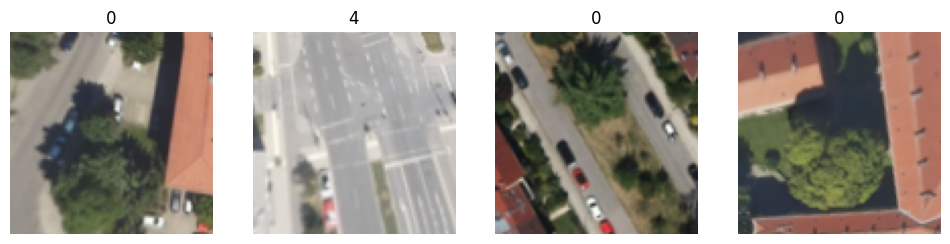

In [157]:
dls.train.show_batch(max_n=4,nrows=1)

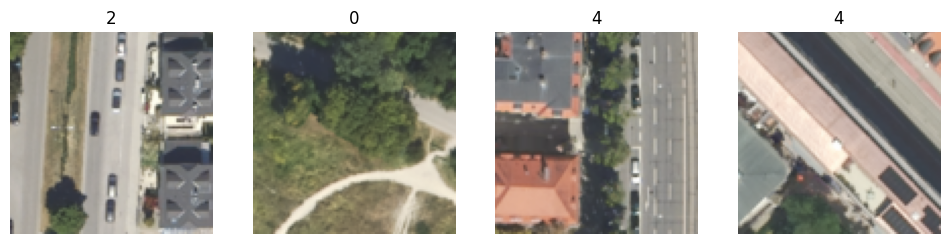

In [158]:
dls.valid.show_batch(max_n=4, nrows=1)

## Model Iteration 1:  5 Categories


### Model1.1 : 5-Categories & ResNet18



Creating the learner:

In [39]:
learn18 = vision_learner(dls, models.resnet18, metrics=accuracy)

Finding the optimal learning rate:

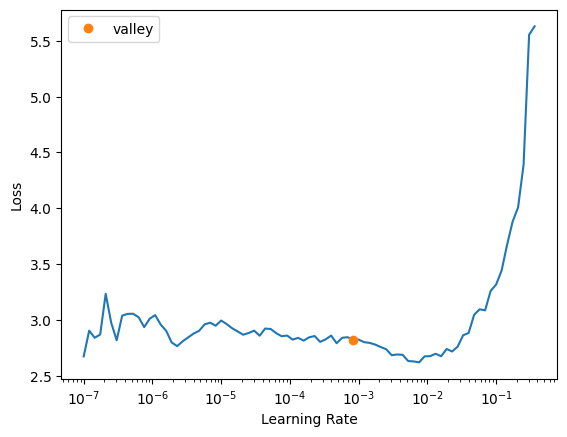

In [47]:
lr = learn18.lr_find()

Training the model with the optimal learning rate:

In [48]:
learn18.fit_one_cycle(20, lr_max=lr.valley)

We create a method that evaluates a given model on. And one that saves a given model.

In [160]:
from fastai.interpret import ClassificationInterpretation
from sklearn.metrics import accuracy_score, precision_score, recall_score

def evaluate_model(learner, dls):
    # Get the model's predictions and the actual targets
    preds, targs = learner.get_preds()

    # Calculate in-sample performance
    in_sample_performance = learner.validate(ds_idx=0)[1]

    # Calculate out-of-sample performance
    out_of_sample_performance = learner.validate(ds_idx=1)[1]

    # Calculate accuracy
    accuracy = accuracy_score(targs, preds.argmax(dim=-1))

    # Calculate precision
    precision = precision_score(targs, preds.argmax(dim=-1), average='macro')

    # Calculate recall
    recall = recall_score(targs, preds.argmax(dim=-1), average='macro')

    # Create a ClassificationInterpretation object for more detailed analysis
    interp = ClassificationInterpretation.from_learner(learner)

    # Plot the top losses
    interp.plot_top_losses(5, nrows=1)

    # Get the indices of the top losses
    top_losses, top_idxs = interp.top_losses(5)

    # Get the filenames of the top losses
    top_loss_filenames = [dls.valid.items[i] for i in top_idxs]

    # Print the filenames
    for filename in top_loss_filenames:
        print(filename)

    # Plot a confusion matrix
    interp.plot_confusion_matrix()

    # Print the results
    print(f"\nIn-sample performance: {in_sample_performance}")
    print(f"Out-of-sample performance: {out_of_sample_performance}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")

def save_learner(learner, model_name):
    learner.export(f'/content/models/{model_name}.pkl')


We use our method to evaluate our model.

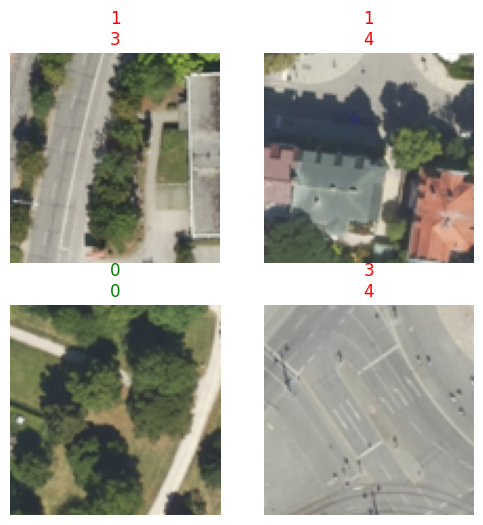

In [51]:
learn18.show_results(max_n=4)

/content/traffic_images/model_img/0/691040_5338080.png
/content/traffic_images/model_img/0/687960_5339520.png
/content/traffic_images/model_img/0/688960_5335680.png
/content/traffic_images/model_img/0/690320_5334160.png
/content/traffic_images/model_img/0/684160_5344240.png


In-sample performance: 0.4728190004825592
Out-of-sample performance: 0.42475569248199463
Accuracy: 0.4247557003257329
Precision: 0.3981825813633724
Recall: 0.43411345987920624


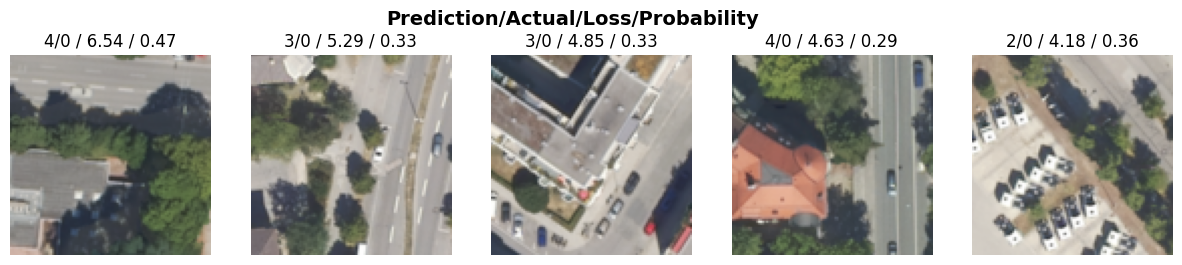

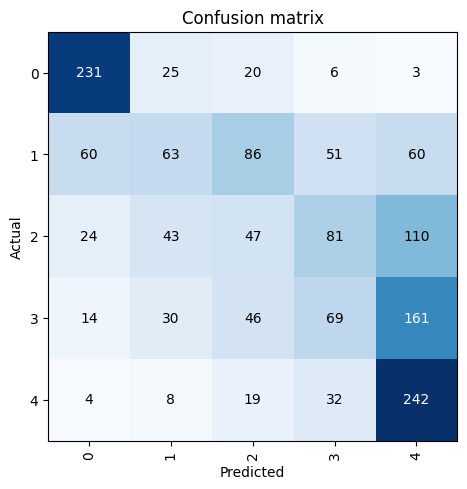

In [162]:
# Now you can call the function with your learner and dataloaders
evaluate_model(learn18, dls)

**Model Evaluation:**

**Model Evaluation:**
- The in-sample performance slightly outperforms the out-of-sample performance by about 0.05. This discrepancy suggests a potential overfitting issue, where the model is more tuned to the training data than generalizing well to new data.
- The model shows notable success in predicting categories 0 and 4:  
    - Category 0, which includes images with diverse features like houses, parks, and football fields, is predicted with high accuracy. This suggests the model's effectiveness in identifying areas with typically low accident risks.
    - Category 4 predominantly features images with extensive street coverage, particularly crossings. The model's ability to recognize these high-risk areas is encouraging.
    - The distinction the model makes between these two extremes (Category 0 and 4) is a positive aspect of its current capability.
- Category 1 presents a unique challenge, as its instances are almost equally distributed across all categories. This indicates a pattern where single accidents occur in varied environments, from low-risk areas like parking slots to unexpected places like crossings. It reflects the unpredictable nature of accidents.
- Categories 2 and 3 are not as accurately predicted, often being skewed towards Category 4. While this misclassification is not ideal, erring on the side of caution (classifying less dangerous areas as more dangerous) could be seen as a safer approach, aligning with our focus on safety.
- The overall accuracy, recall, and precision are not at the desired level, indicating room for improvement in future model iterations.
- A detailed analysis of specific misclassifications, such as investigating why the image '691040_5338080.png' was incorrectly categorized as 4 instead of 0, reveals useful insights. By expanding the analysis range (see screenshot below), we observed nearby high-accident areas, which could have influenced the model's decision. This deeper dive into misclassifications will be invaluable for refining the model.


In summary, while the model demonstrates a good understanding of certain categories and safety dynamics, there's a significant opportunity for enhancement in its overall predictive accuracy and handling of more nuanced scenarios. Further refinements and investigations are essential for the next stages of model development.



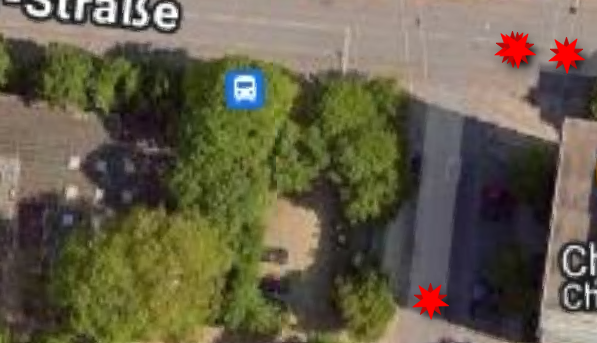

In [1]:

Image(filename='C:\\Projekte\\TDS\\TDS2324-TrafficAccidents\\Data\\Images\\analyis\\accidents_around_691040_5338080.png')


saving the model:

In [135]:
save_learner(learn18, 'learn18')

### Model 1.2: 5-Categories & ResNet34 

In [53]:
learn34 = vision_learner(dls, resnet34, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 155MB/s]


finding the optimal learning rate:

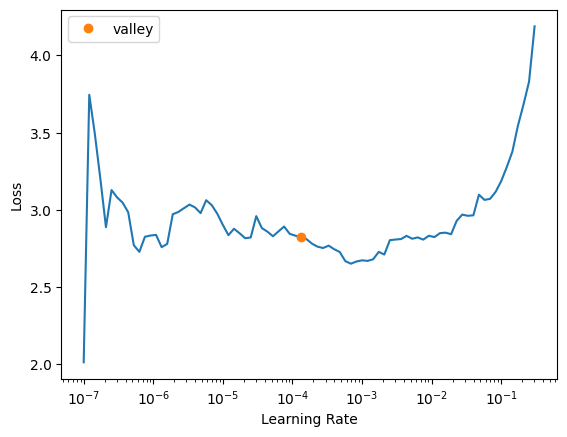

In [56]:
lr = learn34.lr_find()

training the model:

In [57]:
learn34.fit_one_cycle(20, lr_max=lr.valley)

evaluating the model on the test data:

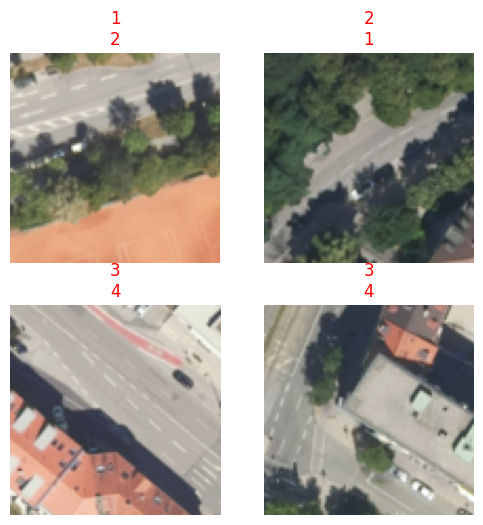

In [60]:
learn34.show_results(max_n=4)

/content/traffic_images/model_img/4/696520_5332800.png
/content/traffic_images/model_img/4/686320_5334120.png
/content/traffic_images/model_img/0/690320_5334160.png
/content/traffic_images/model_img/0/691160_5331520.png
/content/traffic_images/model_img/0/688960_5335680.png


In-sample performance: 0.4251302182674408
Out-of-sample performance: 0.39153093099594116
Accuracy: 0.39153094462540716
Precision: 0.36527260941219236
Recall: 0.39895150273224045


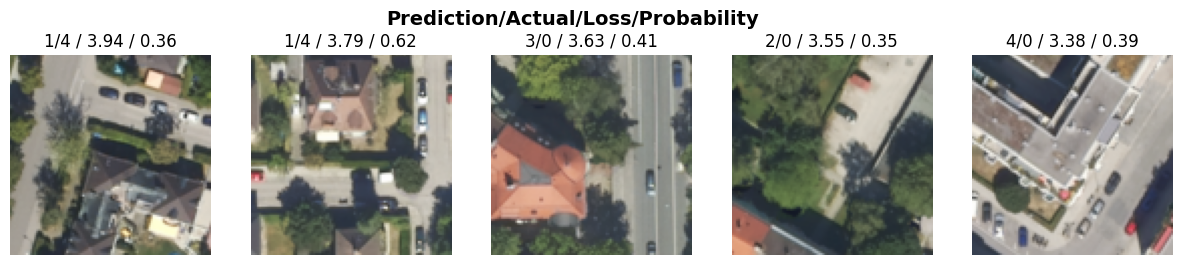

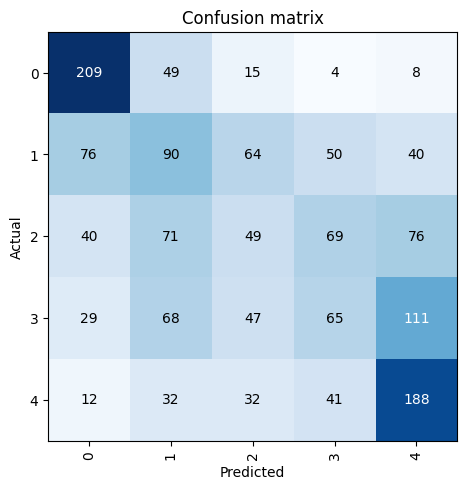

In [163]:
evaluate_model(learn34,dls)

**Model Evaluation:**
- The overfitting concern appears slightly mitigated, with the performance gap between in-sample and out-of-sample narrowing to approximately 0.03. This suggests a modest enhancement in the model's ability to generalize.

- The model demonstrates a commendable job again in predicting Categories 0 and 4. These categories, defined by clear and distinctive features, seem to be well-captured by the model's learning patterns.

- Category 1's predictions show a marginal improvement, with a slight inclination towards Category 0. This could suggest an evolving model perception of lower-risk areas.

- Interestingly, Category 2's predictions are now dispersed across all categories, mirroring the previous model's behavior with Category 1. This diffusion indicates a continued challenge in distinguishing moderate-risk scenarios.

- The model still struggles with Categories 2 and 3, predominantly confusing them with Category 4. Although not ideal, this tendency to err on the side of caution is in line with a conservative, safety-first approach, favoring the misclassification of less dangerous areas as more risky.

- The first two images are classified as Category 1 instead of their actual Category 4. At first glance, this is surprising because both images prominently feature crossings—a characteristic typically associated with higher accident risk categories. However, upon closer inspection, the presence of green spaces such as bushes, grass, and trees could be misleading the model. Additionally, the presence of houses in both images might further lead the model to favor a lower risk category. A low misclassification probability might signal this mix-up between features indicative of a park-like setting and an urban crossing.

- Another noteworthy misclassification is that of the last image, which the model incorrectly identifies as a high-risk area, potentially a crossroad, due to the visible abundance of cars and concrete. This misjudgment illustrates the model's difficulty in differentiating between a parking lot and a crossing, as the image shares characteristics common to both settings.

In comparison to the first iteration, this model maintains a similar performance level, without significant advancements in distinguishing between Categories 1, 2, and 3. This persisting challenge suggests a potential reevaluation of the categorization strategy—perhaps consolidating these categories could lead to a more discerning and effective model.

While the model's overall precision and recall may not have reached new heights, the insights gained point to a strategic opportunity: simplifying the categorization could enhance the model's predictive prowess and provide clearer guidance for safety measures.


saving the model:

In [137]:
save_learner(learn34, 'learn34')

### Model1.3: 5-Categories & ResNet50

In [62]:
learn50 = vision_learner(dls, resnet50, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 93.3MB/s]


finding the optimal learning rate:

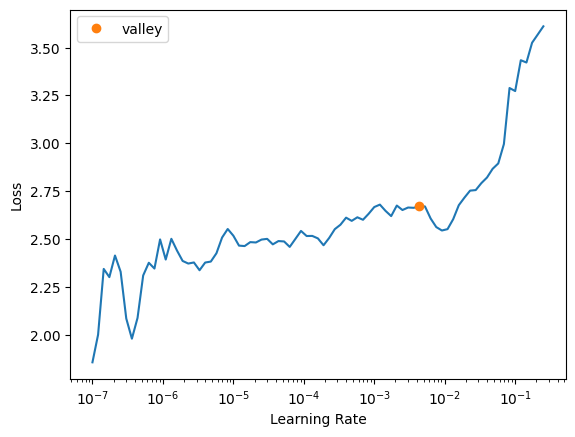

In [66]:
lr = learn50.lr_find()

training the model:

In [67]:
learn50.fit_one_cycle(20, lr_max=lr.valley)

evaluating the model on the test data:

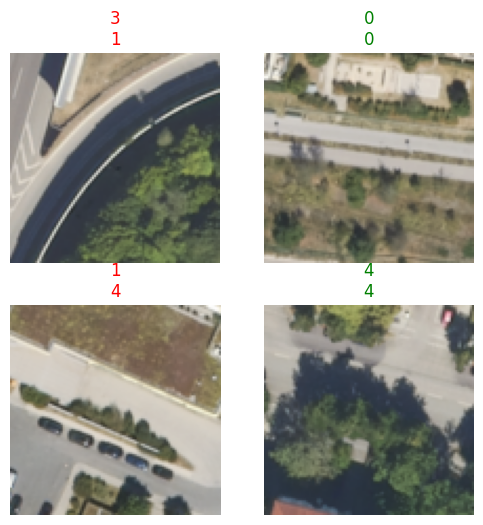

In [70]:
learn50.show_results(max_n=4)

/content/traffic_images/model_img/0/699800_5338320.png
/content/traffic_images/model_img/0/682240_5343360.png
/content/traffic_images/model_img/0/687560_5335080.png
/content/traffic_images/model_img/4/697920_5334480.png
/content/traffic_images/model_img/1/686200_5335360.png


In-sample performance: 0.3701171875
Out-of-sample performance: 0.3478827476501465
Accuracy: 0.3478827361563518
Precision: 0.3248609977392768
Recall: 0.3571528976128847


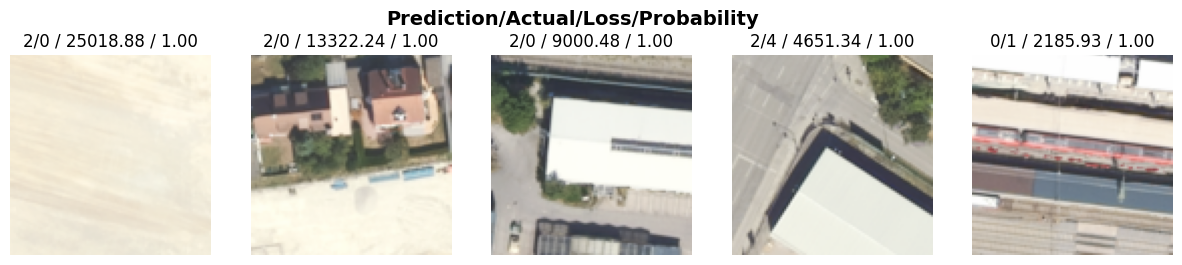

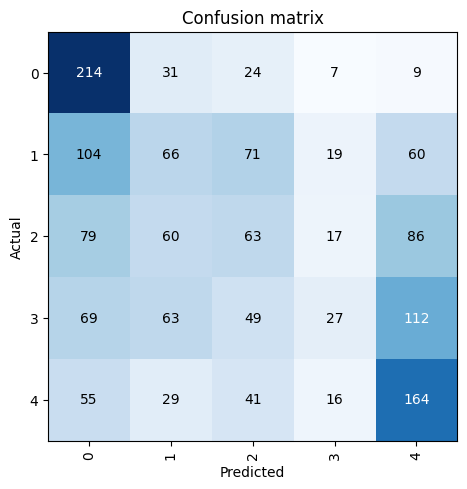

In [164]:
evaluate_model(learn50,dls)

**Model Evaluation:**

- The in-sample and out-of-sample performance metrics have not shown any substantial improvement. This suggests that the model has not gained a better understanding of the data or improved its ability to generalize.

- A peculiar observation from the top 5 losses is the presence of unexpectedly high loss values and mispredictions with probabilities of exactly 1. This indicates a high level of confidence in incorrect predictions. 
    - The unusual phenomena observed in the ResNet50 model's performance—particularly the high confidence in incorrect predictions—could likely be related to the behavior of the validation loss across training epochs. An enormous increase in validation loss by the 7th epoch, coupled with only a minimal gain in accuracy, suggests that the model is beginning to fit noise or irrelevant patterns in the training data rather than learning generalizable features.

- The prediction tendency away from the middle categories (1, 2, and 3) and towards the extremes (0 and 4) indicates the model is more decisive in its categorization, for better or worse. It seems to be more binary in its decision-making, which can be problematic if the middle categories represent a significant portion of the data.

- The deterioration in the model's ability to predict Category 4 correctly is a critical safety concern. Unlike the previous models, which had minimal misclassifications for Category 4 as Category 0, this model's 55 misclassifications in this regard are alarmingly high and could have serious implications for its use in safety-critical applications.

- The continued poor performance in terms of accuracy, precision, and recall underscores the need for further model refinement or a reevaluation of the modeling approach altogether. It's clear that the model is not yet capturing the nuances of the data effectively.

In summary, while moving to a more complex model like ResNet50, the expected increase in performance has not materialized. Instead, we see a model that is confident but often incorrect in its predictions, particularly concerning in terms of safety and reliability. Further investigation into the training process, data quality, and model suitability is required to address these issues.

In [140]:
save_learner(learn50, 'learn50')

## Model Iteration 2:  3 Categories

Acknowledging the challenges faced with the 5-category model, a pivot in strategy is sensible. The model's difficulty in distinguishing between categories 1, 2, and 3 suggests that these categories may not be distinct enough in terms of the features that the model can learn from the images. Simplifying the categorization into three broader categories is a logical step to address this:

- **Category 0:** This category remains unchanged, representing images with 0 accidents, which likely include a variety of non-traffic elements such as buildings, parks, and other structures or natural features.

- **Category 1:** Now encompasses what previously were categories 1 to 3, standing for images with 1 to 4 accidents. This amalgamation reflects a range of low to moderately accident-prone areas, which might share common visual indicators in the imagery.

- **Category 2:** Represents images with 5 or more accidents, capturing the higher risk locations. These are typically areas with a higher concentration of traffic elements, such as busy intersections or stretches of road with frequent accidents.

By redefining the categories, the new approach aims to reduce the model's confusion and improve its ability to make more accurate and reliable predictions. It's a strategic simplification to enhance the model's performance, particularly by creating more distinct and recognizable patterns between categories. This revised categorization is expected to yield better differentiation and generalization, which are critical for the practical application of the model in assessing traffic accident risks.

In [74]:
with zipfile.ZipFile('/content/model_img_2.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/traffic_images')

In [75]:
crash_categories = '0','1','2'
path = Path('/content/traffic_images/model_img_2')

creating the data blocks:

In [76]:
crash_images = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(valid_pct=0.2, seed=42),
                 get_y=parent_label,
                 batch_tfms=aug_transforms())

creating the data loaders and inspecting a batch:

In [138]:
dls2 = crash_images.dataloaders(path, batch_size=4)

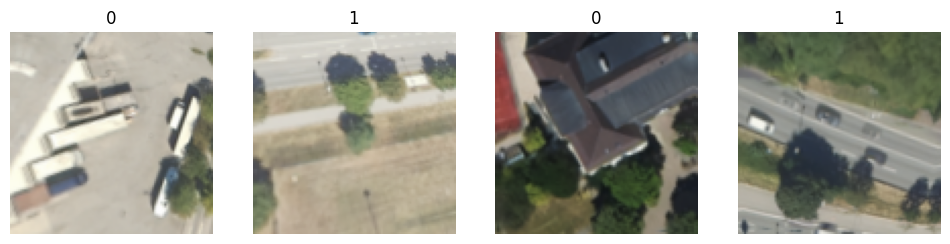

In [139]:
dls2.train.show_batch(max_n=4,nrows=1)

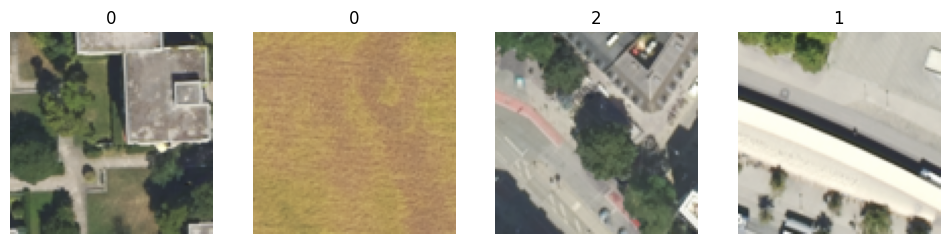

In [141]:
dls2.valid.show_batch(max_n=4,nrows=1)

### Model: 3-Categories & ResNet18

In [80]:
learn18_2 = vision_learner(dls2, resnet18, metrics=accuracy)

identifying the optimal learning rate:

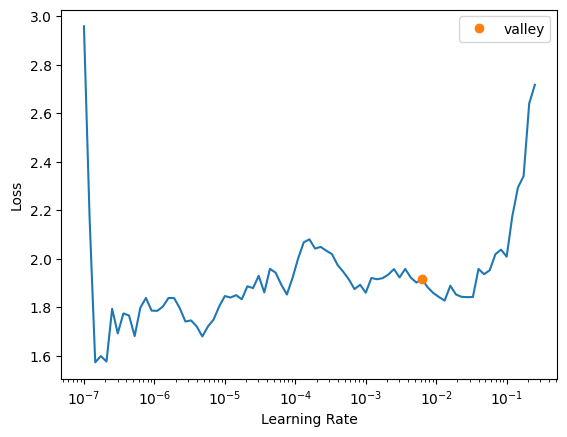

In [85]:
lr = learn18_2.lr_find()

training the model with the optimal learning rate:

In [86]:
learn18_2.fit_one_cycle(20, lr_max=lr.valley)

evaluating the model on the test data:

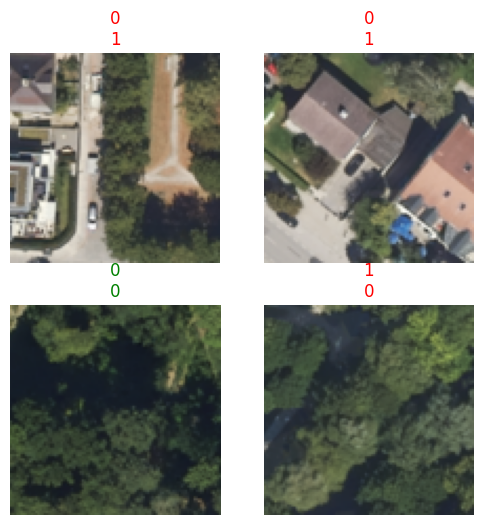

In [89]:
learn18_2.show_results(max_n=4)

/content/traffic_images/model_img_2/0/682200_5335800.png
/content/traffic_images/model_img_2/0/691680_5332680.png
/content/traffic_images/model_img_2/0/698920_5333000.png
/content/traffic_images/model_img_2/0/688440_5331920.png
/content/traffic_images/model_img_2/0/690760_5339680.png


In-sample performance: 0.7086111307144165
Out-of-sample performance: 0.698888897895813
Accuracy: 0.6988888888888889
Precision: 0.7017727022711343
Recall: 0.6958120125069284


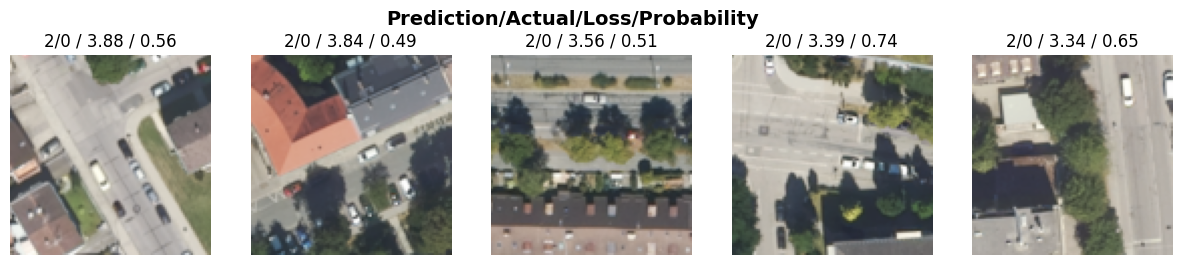

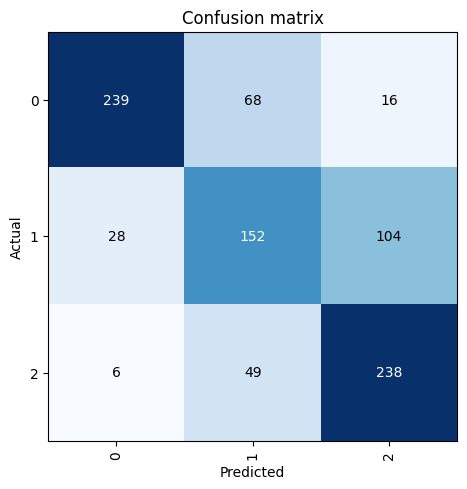

In [165]:
evaluate_model(learn18_2, dls2)

**Model Evaluation:**

The restructured categorization into three classes has yielded a notable improvement in the model's performance:

- Achieving an accuracy of nearly 70%, the model has shown a significant upgrade in its predictive capabilities by consolidating the categories.

- The low rate of misclassification from Category 2 (high-risk) to Category 0 (no-risk) is particularly encouraging from a safety perspective. It suggests the model is less likely to underestimate dangerous areas, which is critical for risk assessment.

- For the first time, the model is performing reasonably well in predicting the intermediary Category 1, with a mild bias towards Category 2 over Category 0. This slight skew towards overestimating risk is preferable in scenarios where erring on the side of caution is advantageous.

- The misclassification of Category 0 occurring approximately 70 times may be attributed to the diverse nature of the images within this category, which includes various non-traffic elements. Roads without accidents in these images could be mistaken as higher risk by the model since Categories 1 and 2 are more street-centric.

- A review of the top losses reveals a consistent pattern: all are misclassified as Category 2 when they should be Category 0. The images, characterized by significant concrete presence and streets, may lead the model to incorrectly infer a higher risk level.

- The absence of overfitting or underfitting points to a well-balanced model, an encouraging sign that the model is generalizing well to new data without losing its predictive strength on the training set.

In conclusion, the model's improved accuracy and balanced performance with the new categorization scheme are promising. While there is still room for refinement, particularly in reducing the misclassification of non-risky areas, the model's current state represents a solid foundation for reliable traffic risk assessment.

In [143]:
save_learner(learn18_2, 'learn18_2')

### Model 2.2: 3-Categories & ResNet34

In [94]:
learn34_2 = vision_learner(dls2, resnet34, metrics=accuracy)

identifying the optimal learning rate:

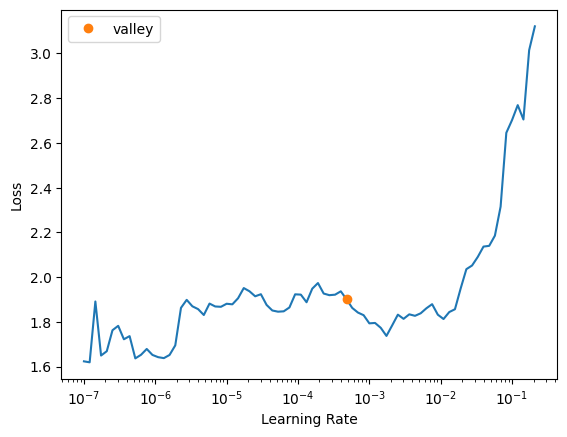

In [97]:
lr = learn34_2.lr_find()

training the model with the optimal learning rate:

In [98]:
learn34_2.fit_one_cycle(20, lr_max=lr.valley)

evaluating the model on the test data:


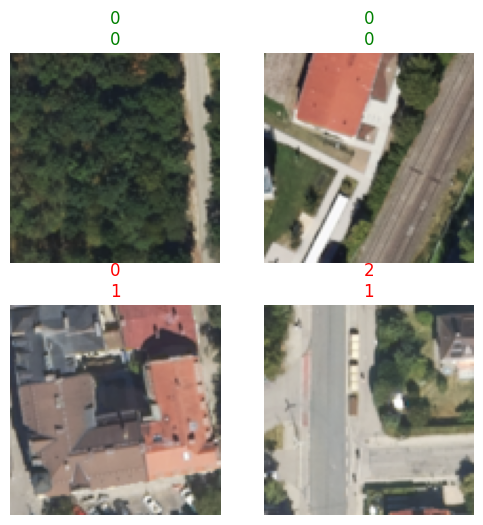

In [101]:
learn34_2.show_results(max_n=4)

/content/traffic_images/model_img_2/0/686360_5330520.png
/content/traffic_images/model_img_2/0/688440_5331920.png
/content/traffic_images/model_img_2/0/682640_5341280.png
/content/traffic_images/model_img_2/1/694160_5334320.png
/content/traffic_images/model_img_2/0/692240_5337080.png


In-sample performance: 0.715833306312561
Out-of-sample performance: 0.699999988079071
Accuracy: 0.7
Precision: 0.6999999999999998
Recall: 0.6955238654105763


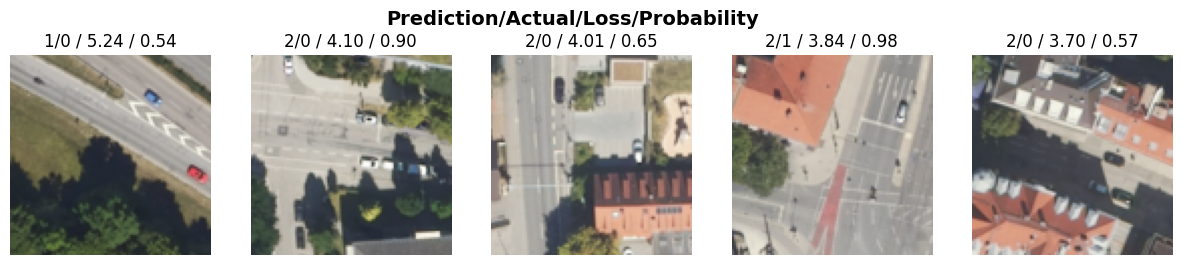

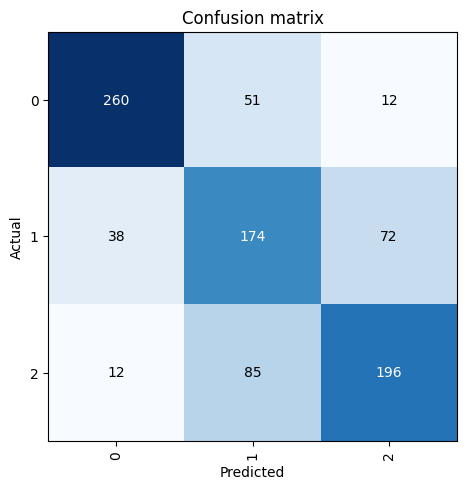

In [168]:
evaluate_model(learn34_2, dls2)

**Model Evaluation:**


- The third model, with a new 3-category system, shows progress compared to its predecessors:

- The metrics for in-sample performance, out-of-sample performance, accuracy, precision, and recall remain consistent with no significant changes, indicating steady model behavior.

- The top losses exhibit characteristics similar to model 2.2, with Category 0 images being erroneously classified as higher categories. This consistency in misclassification suggests that certain features in Category 0 images, such as concrete and streets, still pose challenges for the model.

- There is a slight improvement in the accuracy of Category 1 predictions. This progress, although modest, is a step in the right direction for the model's ability to discern between no accidents and a small number of accidents.

In general, the model's minor improvements are encouraging, especially in a context where fine-tuning the categorization has led to better performance. However, the improvements are marginal, indicating that further adjustments or a more in-depth analysis of the misclassified images may be necessary to achieve significant advancements in model accuracy and reliability

In [145]:
save_learner(learn34_2, 'learn34_2')

### Model 2.3: 3-Categories & ResNet50

In [104]:
learn50_2 = vision_learner(dls2, resnet50, metrics=accuracy)

identifying the optimal learning rate:

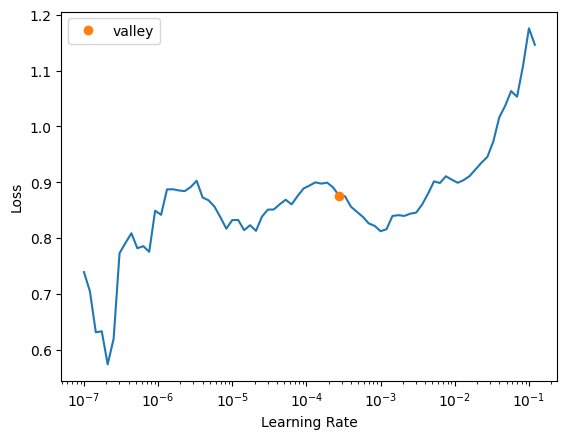

In [114]:
lr = learn50_2.lr_find()

training the model with the optimal learning rate:

In [115]:
learn50_2.fit_one_cycle(20, lr_max=lr.valley)

evaluating the model on the test data:

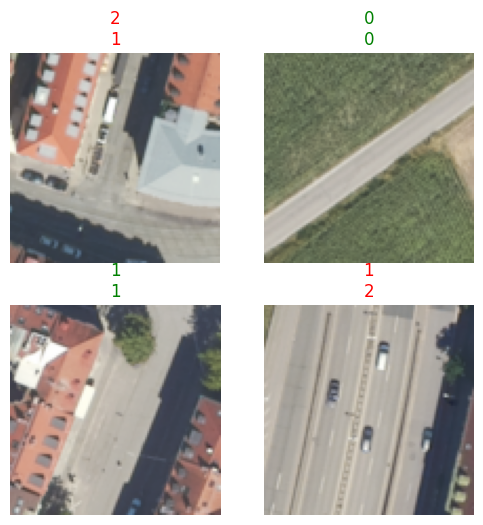

In [148]:
learn50_2.show_results(max_n=4)

/content/traffic_images/model_img_2/0/700000_5333320.png
/content/traffic_images/model_img_2/0/684680_5334360.png
/content/traffic_images/model_img_2/0/700160_5338680.png
/content/traffic_images/model_img_2/0/693120_5340720.png
/content/traffic_images/model_img_2/0/684720_5340920.png


In-sample performance: 0.6552777886390686
Out-of-sample performance: 0.6466666460037231
Accuracy: 0.6466666666666666
Precision: 0.642994433884683
Recall: 0.6419691715100034


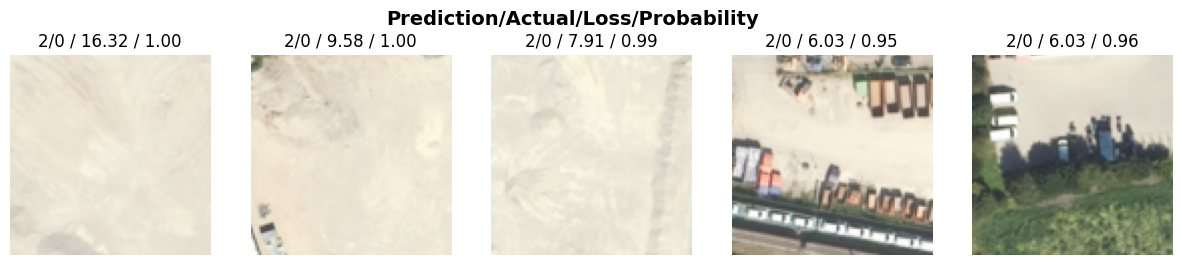

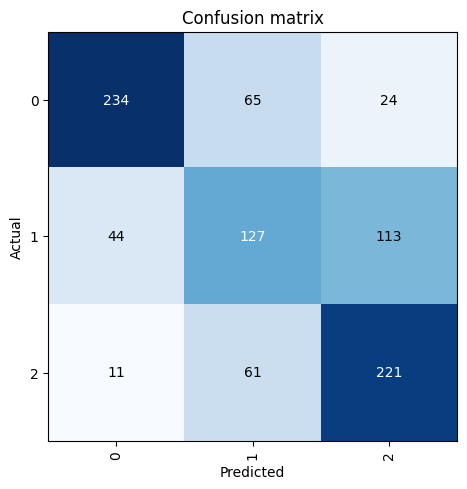

In [167]:
evaluate_model(learn50_2, dls2)

**Model Evaluation:**
The updated model appears to have encountered some challenges:

- Echoing the behavior of model 1.3 with ResNet50, this model also exhibits overconfidence in its predictions, as evidenced by near-certain probabilities assigned to incorrect classifications. But the validation loss did not increase in the dimension it did in model 1.3.

- The top losses pattern persists, with the model tending to incorrectly predict higher-risk categories for what are actually Category 0 images. This misclassification could be due to the model overemphasizing certain features associated with higher risk, such as the presence of roads or intersections, even in areas where no accidents have occurred.

- The observation regarding the top-5 losses is quite intriguing. The first three images being similar and all misclassified could indeed suggest that there's a particular feature or set of features that the model is consistently interpreting incorrectly. The fact that these images are of sand near a sea( see picture below) and the hypothesis that the model may be confusing them with a wide street or similar structure is a plausible explanation. This kind of landscape may present visual similarities to urban features that the model has learned to associate with higher risk categories.

- In terms of overall performance, there has been a noticeable decline, with accuracy dropping to 64%. This regression suggests the model may not be effectively capturing the nuances between the categories as the previous model iterations did.

- A closer look at the confusion matrix indicates that the predictability of Category 1 has deteriorated, which further contributes to the overall decrease in performance.

In summary, rather than seeing improvements, this iteration of the model has experienced slight setbacks. The heightened overconfidence in misclassifications and the reduced ability to correctly identify Category 1 are concerning. These factors underscore the need for a deeper dive into the model's learning process, potential biases in the training data, or even a reassessment of the current approach to categorization and feature extraction.

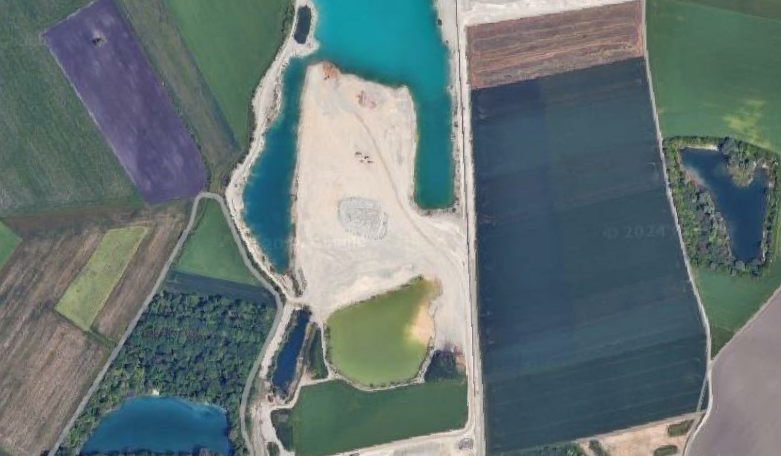

In [9]:
Image(filename='C:\\Projekte\\TDS\\TDS2324-TrafficAccidents\\Data\\Images\\analyis\\3_top_losses.png')

In [150]:
save_learner(learn50_2,'learn50_2')

## Model Evaluation Summary
The evaluation of various models trained to predict traffic accident risk from satellite imagery has yielded a number of insights:

- The models with three risk categories consistently outperformed those with five. The simplified categorization resulted in a higher overall accuracy, suggesting that fewer, broader categories may be more distinguishable for the model.

- Among the 3-category models, ResNet 34 emerged as the superior architecture, achieving marginally better results than ResNet 18 and performing better than model 1.3 (3-Categroies & ResNet 50). This suggests that the added complexity of ResNet 50 may not be beneficial for this specific task, and a mid-level architecture like ResNet 34 strikes a better balance between model complexity and performance.

- A notable achievement of the 3-category models, and particularly of ResNet 34, was the improved prediction of Category 1, the middle category. This category had been challenging for the models to predict accurately, and the improved performance here is a significant step forward.

- A discernible pattern in the top losses for the 3-category models was the misclassification of streets without accidents (Category 0) as higher-risk categories. This pattern was not evident in the 5-category models, suggesting that the increased granularity of the categories may have made it more difficult for the models to learn distinct features associated with each category.

-  The confusion matrix for the 3-category models indicates that while there is still some confusion between categories, the extent of misclassification is reduced compared to the 5-category models. This is especially true for the middle category, which is a significant improvement.


- The tendency of models to overestimate the risk of zero-accident streets could be considered a safety feature, as it errs on the side of caution. However, it's important to balance this with the need for accurate risk assessment to avoid misallocation of resources. Especially since we did not train our model in this direction on purpose.


In summary, the shift to a 3-category model has been beneficial, with ResNet 34 standing out as the best performing architecture. The findings point to the importance of aligning model complexity with the specificity of categorization and indicate that there is potential for further optimization. 


## Online Application of the Predictor

defining the image classification function:

In [9]:
#loading the labels
learner = load_learner('/content/models/learn34_2.pkl')
labels = learner.dls.vocab

def classify_image(satellite_image):
  inp = inp.reshape((-1, 100, 100, 3))
  prediction = learn34_2.predict(inp).flatten()
  confidences = {labels[i]: float(prediction[i]) for i in range(1000)}
  return confidences

deploying the gradio interface:

In [13]:
crash_predictor = gr.Interface(fn=classify_image,
             inputs=gr.Image(),
             outputs=gr.Label(num_top_classes=len(labels)))
crash_predictor.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://a67bece3ad7939435e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
